# Fetch some tidegauge data

Fetch data for the Westport and Aberdeen gauges, from the King tide period of December, 2015.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import datetime
from scipy.interpolate import interp1d
from clawpack.geoclaw import util
import clawpack.pyclaw.gauges as gauges

## Download tide gauge data for Westport and Aberdeen

In [3]:
station_westport = '9441102'
MLW_westport = -1.068 # m relative to MTL
MHW_westport = 1.068  # m relative to MTL

station_aberdeen = '9441187'
MLW_aberdeen = -1.21  # m relative to MTL
MHW_aberdeen = 1.21  # m relative to MTL

begin_date = datetime.datetime(2015,12,21)
end_date = datetime.datetime(2015,12,26)
time_zone = 'GMT'
datum = 'MTL'
units = 'metric'
cache_dir = '.'

time_westport, eta_westport, etap_westport = \
    util.fetch_noaa_tide_data(station_westport, begin_date, end_date,
                              time_zone, datum, units, cache_dir)

time_aberdeen, eta_aberdeen, etap_aberdeen = \
    util.fetch_noaa_tide_data(station_aberdeen, begin_date, end_date,
                              time_zone, datum, units, cache_dir)

Using cached water_level data for station 9441102
Using cached predictions data for station 9441102
Fetching water_level data from NOAA for station 9441187
*** Fetching water_level failed, returning None
Using cached predictions data for station 9441187


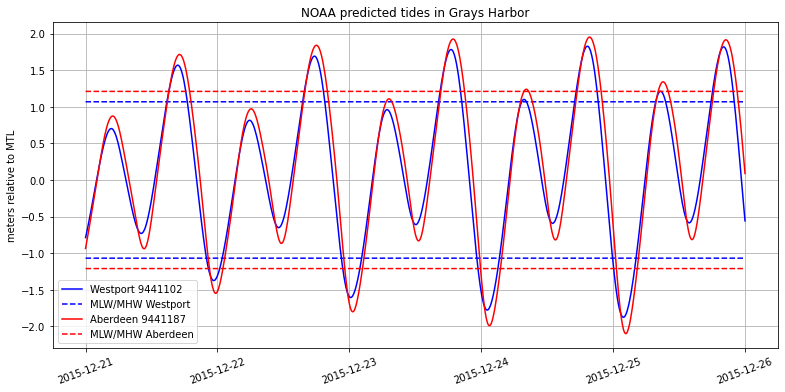

In [4]:
figure(figsize=(13,6))
plot(time_westport, etap_westport, 'b', label='Westport %s' % station_westport)
plot(time_westport, MHW_westport*ones(time_westport.shape),'b--', label="MLW/MHW Westport")
plot(time_westport, MLW_westport*ones(time_westport.shape),'b--')

plot(time_aberdeen, etap_aberdeen, 'r', label='Aberdeen %s' % station_aberdeen)
plot(time_aberdeen, MHW_aberdeen*ones(time_aberdeen.shape),'r--', label="MLW/MHW Aberdeen")
plot(time_aberdeen, MLW_aberdeen*ones(time_aberdeen.shape),'r--')

grid(True)
xticks(rotation=20)
legend()
title('NOAA predicted tides in Grays Harbor')
ylabel('meters relative to %s' % datum);

### Convert datetimes to elapsed seconds

In [5]:
# convert to elapsed seconds:
dt_westport = time_westport - time_westport[0]
t_westport = array([dt.item().total_seconds() for dt in dt_westport])

dt_aberdeen = time_aberdeen - time_aberdeen[0]
t_aberdeen = array([dt.item().total_seconds() for dt in dt_aberdeen])

## Compute desired ocean forcing

In [6]:
# lag time so forcing in ocean reaches Westport at desired time:
dt_ocean_to_westport = 2700.   # from tests
t_ocean = t_westport - dt_ocean_to_westport
t = t_ocean

# decrease amplitude in ocean based on observed growth:
eta_growth_ocean_to_westport = 1.1
etap_ocean = etap_westport / eta_growth_ocean_to_westport
eta = etap_ocean

etap_ocean_fcn = interp1d(t_ocean,etap_ocean,kind='linear')
print('Ocean level at t=0 is %.3f m relative to %s' \
        % (etap_ocean_fcn(0), datum))

Ocean level at t=0 is -0.468 m relative to MTL


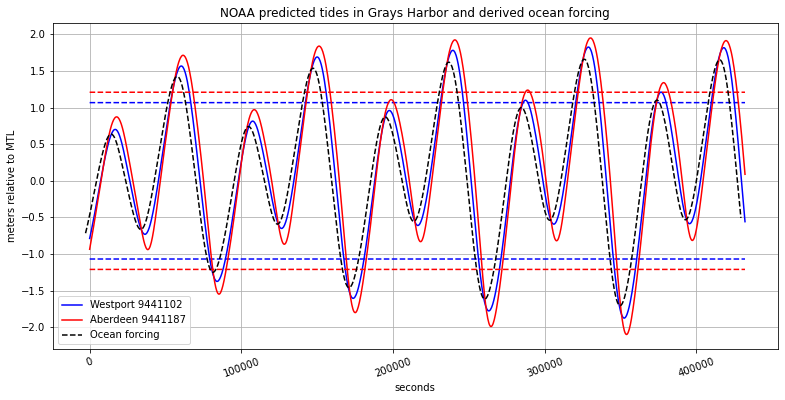

In [7]:
figure(figsize=(13,6))
plot(t_westport, etap_westport, 'b', label='Westport %s' % station_westport)
plot(t_westport, MHW_westport*ones(t_westport.shape),'b--')
plot(t_westport, MLW_westport*ones(t_westport.shape),'b--')

plot(t_aberdeen, etap_aberdeen, 'r', label='Aberdeen %s' % station_aberdeen)
plot(t_aberdeen, MHW_aberdeen*ones(t_aberdeen.shape),'r--')
plot(t_aberdeen, MLW_aberdeen*ones(t_aberdeen.shape),'r--')

plot(t_ocean, etap_ocean, 'k--', label='Ocean forcing')

grid(True)
xticks(rotation=20)
xlabel('seconds')
legend()
title('NOAA predicted tides in Grays Harbor and derived ocean forcing')
ylabel('meters relative to %s' % datum);

## Compute derivative $\eta'(t)$ to use for ocean forcing term

In GeoClaw we add a source term to the mass equation so that it becomes
$$
h_t + (hu)_x + (hv)_y = \eta'(t)
$$
everywhere in the ocean sufficiently far offshore. Starting with the ocean at rest, and in the absence of any propagating waves this gives $h(x,y,t) = \eta(t)$ in this region, as desired.

Create a text file with columns `t, eta(t), etaprime(t)`.

In [8]:
fname = 'tidedata_dec2015.txt'

etaprime = (eta[2:]-eta[:-2])/(t[2:]-t[:-2])  # central diff at interior t
etaprime = hstack(((eta[1]-eta[0])/(t[1]-t[0]), etaprime, \
                   (eta[-1]-eta[-2])/(t[-1]-t[-2])))

d = vstack((t, eta, etaprime)).T

mt = d.shape[0]
header = '%i  # mt' % mt
savetxt(fname, d, header=header, comments='')
print('Created ',fname)

Created  tidedata_dec2015.txt


## Plot GeoClaw results

After running the GeoClaw code, plot the simulated gauges together with the observations...

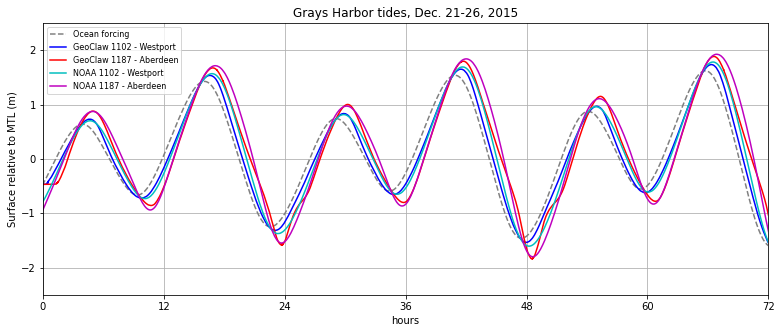

In [9]:
outdir = '_output'

figure(figsize=(13,5))
colors = ['b','r','m','g']

plot(t_ocean/3600., etap_ocean, color=[.5,.5,.5],
     linestyle='--', label='Ocean forcing')

for k,gaugeno in enumerate([1102,1187]):
    gauge = gauges.GaugeSolution(gaugeno, outdir)
    t = gauge.t / 3600.   # convert to hours
    q = gauge.q
    eta = q[3,:]
    if gaugeno==1102:
        plot(t, eta, colors[k], label='GeoClaw 1102 - Westport')
    elif gaugeno==1187:
        plot(t, eta, colors[k], label='GeoClaw 1187 - Aberdeen')
    else:
        plot(t, eta, colors[k], label='GeoClaw Gauge %s' % gaugeno)
        
plot(t_westport/3600., etap_westport, 'c', label='NOAA 1102 - Westport')
plot(t_aberdeen/3600., etap_aberdeen, 'm', label='NOAA 1187 - Aberdeen')

xlim(0,96)
ylim(-2.5,2.5)
legend(loc='upper left', fontsize=8)
xlabel('hours')
ylabel('Surface relative to MTL (m)')
title('Grays Harbor tides, Dec. 21-26, 2015')
grid(True)

xlim(0,t[-1])
# ticks every 12 hours:
xticks(arange(0,t[-1]+0.1,12));

## Notes:

- In the figure above the dashed black line is the tide expected from the ocean forcing. The blue and red curves show the resulting GeoClaw gauge results at Westport and Aberdeen respectively, while the cyan and magenta curves are the NOAA observations at these gauges.

- The simulated gauges show good agreement with the observations.  In particular, the timing of the peak tide arrivals at the two gauges (about 18 minutes later at Aberdeen than Westport) and the greater amplification at Aberdeen are properly modeled.